<a href="https://colab.research.google.com/github/Tran-Thu-Le/ttlblog/blob/main/math/Blasso_with_continuous_opt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

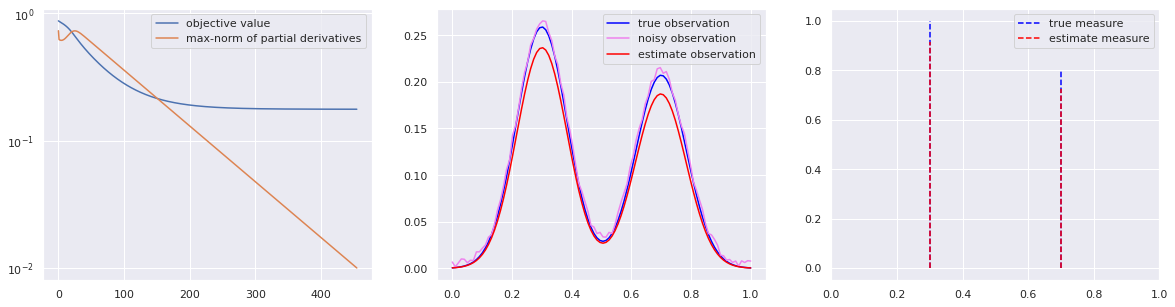

In [ ]:
import torch 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme() 

def dic(x, t, w):
    diff = x.reshape(-1, 1) - t.reshape(1, -1)
    g = torch.pow(2, -diff**2/w**2)
    norm = g.norm(p=2, dim=0)
    return g/norm


def opt_min(func, point, lr=1e-2, max_iters=500, epsilon=1e-2):
    point.clone()
    data = {
        "val": [],
        "grad_max": [],
    }

    for i in range(max_iters):
        point.requires_grad = True 
        point.grad =  torch.zeros(point.shape)
        loss = func(point)
        loss.backward()
        grad = point.grad 
        point = point - lr * grad 
        # detach 
        loss = loss.detach()
        grad = grad.detach()
        point = point.detach()
        # save 
        grad_max = grad.abs().max()
        data["val"] += [loss]
        data["grad_max"] += [grad_max]
        # stop
        if grad_max<epsilon:
            break

    return point, data


def test():
    x = torch.linspace(0., 1., 100)
    w =0.1 

    p0 = torch.tensor([0.3, 0.7])
    c0 = torch.tensor([1., 0.8])
    y0 = dic(x, p0, w) @ c0.reshape(-1, 1)

    noise = torch.rand(y0.shape)
    y = y0 + 1e-2 * noise

    lbd = 0.1

    t = torch.linspace(0., 1., 10)
    def func(point):
        p, c = point
        a = 0.5 * (y - dic(x, p, w) @ c.reshape(-1, 1)).norm()**2
        b = lbd * c.norm(p=1)
        return a+b

    p = torch.tensor([0.2, 0.8])
    c = torch.tensor([0., 0.])
    point = torch.cat([p, c]).reshape(2, -1)
    point_est, data = opt_min(func, point)
    p_est, c_est = point_est

    y_hat = dic(x, p_est, w) @ c_est.reshape(-1, 1)

    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
    ax1.plot(data["val"], label="objective value")
    ax1.plot(data["grad_max"], label="max-norm of partial derivatives")
    ax1.set_yscale("log") 
    ax1.legend()

    ax2.plot(x, y0.reshape(-1), label="true observation", color="blue")
    ax2.plot(x, y.reshape(-1), label="noisy observation", color="violet")
    ax2.plot(x, y_hat.reshape(-1), label="estimate observation", color="red")
    ax2.legend()

    ax3.vlines(x=p0, ymin=0., ymax=c0, label="true measure", color="blue", ls="--")
    ax3.vlines(x=p_est, ymin=0., ymax=c_est, label="estimate measure", color="red", ls="--")
    ax3.set_xlim(0., 1.)
    ax3.legend()

    plt.show()


test()


